In [1]:
import os ,yaml
from operator import itemgetter
from tools.import_data import *
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [5]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs

In [6]:
def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True)
        try:
            cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold,n_jobs=-1, scoring=SCORING )
        except ValueError as e:
            print('ValueError{}'.format(None))
        else:
            scores.append(cv_results)
            names.append(name)
            results.append({"name":name,"score":cv_results.mean()})
            # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            # print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
        
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    results = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        # print('Model ' , name)
        # print('Accuracy: ', accuracy_score(Y_test, predictions))
        results.append({"name":name,"score":accuracy_score(Y_test, predictions)})
        #print(confusion_matrix(Y_validation, predictions))
        # print(classification_report(Y_test, predictions))
    return results 
    # 
    # encoder(predict_dataset)
    # #print (predict_dataset)
    # predict=predict_dataset.values[:,0:22]
    # 
    # predictions = lr.predict(predict)
    
    # temp = pandas.DataFrame(predict)
    # temp['class'] = predictions
    # temp.to_csv('predict.csv')
def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    name = results[i]["name"]
    printmd('The best model for the given data is: <span style="color:green">' + str(name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)

# def information_gain(X, y):
#     def _entropy(labels):
#         counts = np.bincount(labels)
#         return entropy(counts, base=None)
# 
#     def _ig(x, y):
#         # indices where x is set/not set
#         x_set = np.nonzero(x)[1]
#         x_not_set = np.delete(np.arange(x.shape[1]), x_set)
# 
#         h_x_set = _entropy(y[x_set])
#         h_x_not_set = _entropy(y[x_not_set])
# 
#         return entropy_full - (((len(x_set) / f_size) * h_x_set)
#                              + ((len(x_not_set) / f_size) * h_x_not_set))
# 
#     entropy_full = _entropy(y)
# 
#     f_size = float(X.shape[0])
# 
#     scores = np.array([_ig(x, y) for x in X.T])
#     return scores

In [7]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = os.path.join(FILE_PATH,'config.yml')
config = yaml.load(open(CONFIG_FILE,'r'))
TRAIN_FILE = config['files']['train_set']
TEST_FILE = config['files']['test_set']
SCORING = config['score']

models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

if __name__ == "__main__":
    X_train, Y_train , original_headers_train = load_dataset(TRAIN_FILE) 
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    if TEST_FILE:
        X_test, Y_test ,original_headers_test = load_dataset(TEST_FILE)
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)

Train data shape:  (776, 21)
Train labels shape:  (776,)


In [9]:
    # Encoding Categorial features and imputing NaN's
    # https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    # http://pbpython.com/categorical-encoding.html
    # https://datascience.stackexchange.com/questions/14069/mass-convert-categorical-columns-in-pandas-not-one-hot-encoding
    char_cols = X_train.dtypes.pipe(lambda x: x[x == 'object']).index
    if not char_cols.empty:
        label_mapping = {}
        for c in char_cols:
            X_train_non_numeric = X_train.copy()
            X_train[c], label_mapping[c] = pd.factorize(X_train[c])
    imp = preprocessing.Imputer(axis=0, verbose=1)
    imp = imp.fit(X_train)
    X_train_imp = imp.transform(X_train)
    print ('New Train data shape: ',X_train_imp.shape)
    
    lb = preprocessing.LabelBinarizer()
    Y_train = lb.fit_transform(Y_train).ravel()
    
    fs_scores = fs.mutual_info_classif(X_train_imp,Y_train)
    feature_scores_list = []
    for i,score in enumerate(fs_scores):
        feature_scores_list.append({'feature_name':original_headers_train[i],'score':score})
    feature_scores_list.sort(key=itemgetter('score'),reverse=True)
    for feature in feature_scores_list:
        print (feature)

New Train data shape:  (776, 21)
{'feature_name': 'SYM_YRS_SINCE_HEARTBURN_START', 'score': 0.16106041247289116}
{'feature_name': 'SYM_YRS_SINCE_ACID_TASTE_START', 'score': 0.12983744456385038}
{'feature_name': 'SYM_BURNING_CHEST', 'score': 0.090326303572347832}
{'feature_name': 'SYM_TAKING_STOMACH_MEDS', 'score': 0.090166334748582599}
{'feature_name': 'SEX', 'score': 0.076157375062050114}
{'feature_name': 'WAIST_CIRCUMFERENCE', 'score': 0.073355059535862521}
{'feature_name': 'HEIGHT', 'score': 0.071671895645036177}
{'feature_name': 'ALC_UNITS_PER_WEEK_AGED_30', 'score': 0.06188355602175144}
{'feature_name': 'SYM_ACID_TASTE', 'score': 0.061737942555244008}
{'feature_name': 'SMK_AGE_SMOKING_STOPPED', 'score': 0.058715314699254062}
{'feature_name': 'WEIGHT', 'score': 0.048742370511456246}
{'feature_name': 'ALC_DRINK_HEAVILY', 'score': 0.04721487083272069}
{'feature_name': 'SYM_CHEST_PAIN', 'score': 0.039641728402259213}
{'feature_name': 'SYM_SLEEP_DISRUPTED', 'score': 0.03407652716273434

In [10]:
    #before we found the elbow
    new_trains = []
    # new_shapes_ratio = []
    # new_range = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        # sel = fs.VarianceThreshold(VTHRESH)
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        # sel.fit(X_train_imp,Y_train)
        # print (sel.get_params())
        # print (sel.get_support())
        X_train_mod = sel.fit_transform(X_train_imp,Y_train)
        if len(new_trains) >= 1:
            if new_trains[-1]['ratio']!= X_train_mod.shape[-1]/X_train.shape[-1]:
                # new_range.append(VTHRESH)
                # new_trains.append(X_train_mod)
                # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
                mask = sel.get_support() #list of booleans
                new_features = [] # The list of your K best features    
                for bool, feature in zip(mask, original_headers_train):
                    if bool:
                        new_features.append(feature)
                new_trains.append({'threshold':VTHRESH,
                                   'X_train':X_train_mod,
                                   'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                                   'features_name':new_features})
                
        else:
            # new_range.append(VTHRESH)
            # new_trains.append(X_train_mod)
            # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
            mask = sel.get_support() #list of booleans
            new_features = [] # The list of your K best features    
            for bool, feature in zip(mask, original_headers_train):
                if bool:
                    new_features.append(feature)
            new_trains.append({'threshold':VTHRESH,
                               'X_train':X_train_mod,
                               'ratio':X_train_mod.shape[-1]/X_train.shape[-1],
                               'features_name':new_features})

**Training Section** for: 1 features (['SYM_YRS_SINCE_HEARTBURN_START'])

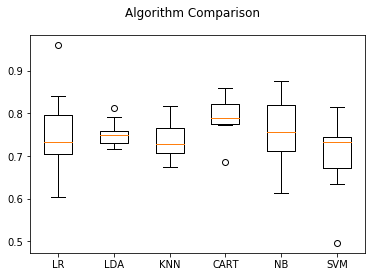

The best model for the given data is: <span style="color:green">CART</span> with the score <span style="color:green">0.792781023222</span>

{'name': 'LR', 'score': 0.75152570149975806}
{'name': 'LDA', 'score': 0.75189250725689405}
{'name': 'KNN', 'score': 0.73526342525399124}
{'name': 'CART', 'score': 0.7927810232220609}
{'name': 'NB', 'score': 0.75539087445573283}
{'name': 'SVM', 'score': 0.70309137639090469}


**Training Section** for: 2 features (['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START'])

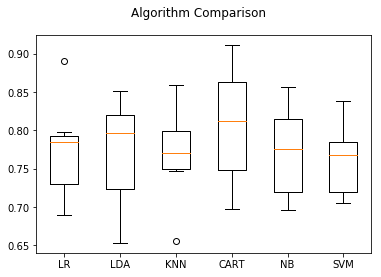

The best model for the given data is: <span style="color:green">CART</span> with the score <span style="color:green">0.804605920416</span>

{'name': 'LR', 'score': 0.77164562167392359}
{'name': 'LDA', 'score': 0.77589223512336725}
{'name': 'KNN', 'score': 0.77043964683115629}
{'name': 'CART', 'score': 0.80460592041606183}
{'name': 'NB', 'score': 0.77096967223028545}
{'name': 'SVM', 'score': 0.76077663884857283}


**Training Section** for: 3 features (['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

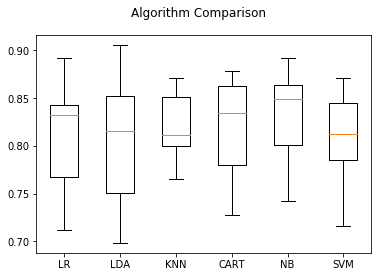

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.82972656628</span>

{'name': 'LR', 'score': 0.80725160256410255}
{'name': 'LDA', 'score': 0.80521797895500724}
{'name': 'KNN', 'score': 0.82069206579583953}
{'name': 'CART', 'score': 0.81920639816158691}
{'name': 'NB', 'score': 0.82972656627963226}
{'name': 'SVM', 'score': 0.80993435534591196}


**Training Section** for: 4 features (['SYM_CHEST_PAIN', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

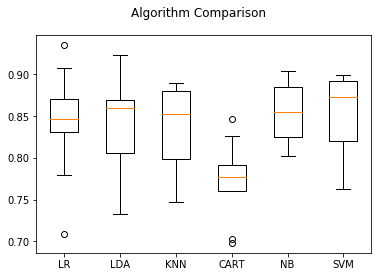

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.853796232463</span>

{'name': 'LR', 'score': 0.84257665094339629}
{'name': 'LDA', 'score': 0.83969046323173691}
{'name': 'KNN', 'score': 0.83445022980164496}
{'name': 'CART', 'score': 0.77299782293178509}
{'name': 'NB', 'score': 0.85379623246250613}
{'name': 'SVM', 'score': 0.85069986695694255}


**Training Section** for: 5 features (['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

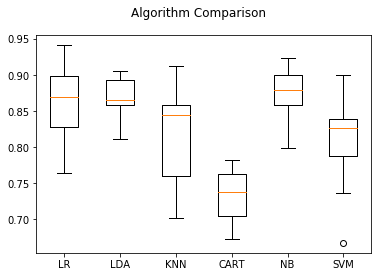

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.872858188195</span>

{'name': 'LR', 'score': 0.86335416666666664}
{'name': 'LDA', 'score': 0.86566527576197383}
{'name': 'KNN', 'score': 0.81989320270924038}
{'name': 'CART', 'score': 0.73234059022738274}
{'name': 'NB', 'score': 0.87285818819545236}
{'name': 'SVM', 'score': 0.80651106676342521}


**Training Section** for: 6 features (['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

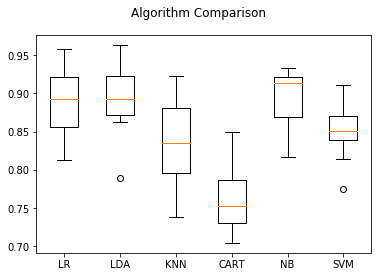

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.895449746009</span>

{'name': 'LR', 'score': 0.88823288582486692}
{'name': 'LDA', 'score': 0.89197532656023226}
{'name': 'KNN', 'score': 0.83428056966618291}
{'name': 'CART', 'score': 0.75822194000967591}
{'name': 'NB', 'score': 0.8954497460087083}
{'name': 'SVM', 'score': 0.85290529753265587}


**Training Section** for: 7 features (['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

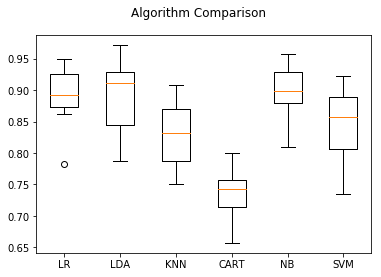

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.898725387034</span>

{'name': 'LR', 'score': 0.89128307934204154}
{'name': 'LDA', 'score': 0.89225849661344936}
{'name': 'KNN', 'score': 0.83045491654571857}
{'name': 'CART', 'score': 0.73560982099661354}
{'name': 'NB', 'score': 0.89872538703434945}
{'name': 'SVM', 'score': 0.84333671988388981}


**Training Section** for: 8 features (['SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

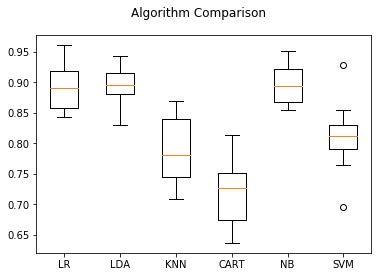

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.896430091921</span>

{'name': 'LR', 'score': 0.89287264150943402}
{'name': 'LDA', 'score': 0.89507916061925497}
{'name': 'KNN', 'score': 0.78801076439283979}
{'name': 'CART', 'score': 0.72085413642960816}
{'name': 'NB', 'score': 0.89643009192065792}
{'name': 'SVM', 'score': 0.81082051282051282}


**Training Section** for: 9 features (['SEX', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

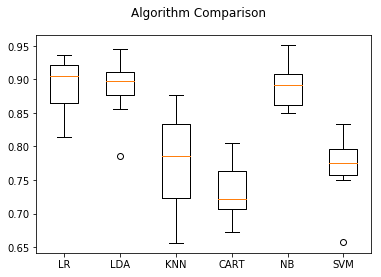

The best model for the given data is: <span style="color:green">NB</span> with the score <span style="color:green">0.891162977746</span>

{'name': 'LR', 'score': 0.89003090227382686}
{'name': 'LDA', 'score': 0.88932837445573298}
{'name': 'KNN', 'score': 0.77504208998548629}
{'name': 'CART', 'score': 0.73354221093372041}
{'name': 'NB', 'score': 0.891162977745525}
{'name': 'SVM', 'score': 0.77098850991775525}


**Training Section** for: 10 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

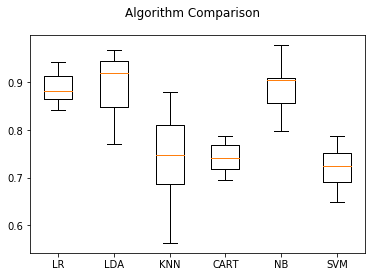

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.89398355104</span>

{'name': 'LR', 'score': 0.88976548137397204}
{'name': 'LDA', 'score': 0.8939835510401547}
{'name': 'KNN', 'score': 0.74031767053701025}
{'name': 'CART', 'score': 0.7424131591678762}
{'name': 'NB', 'score': 0.89229311804547662}
{'name': 'SVM', 'score': 0.72163776003870339}


**Training Section** for: 11 features (['AGE', 'SEX', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

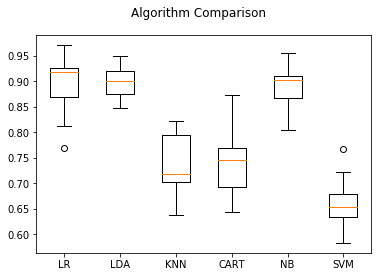

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.896664852443</span>

{'name': 'LR', 'score': 0.89137814465408804}
{'name': 'LDA', 'score': 0.8966648524431543}
{'name': 'KNN', 'score': 0.7343418601838414}
{'name': 'CART', 'score': 0.74199540396710217}
{'name': 'NB', 'score': 0.89068571601354607}
{'name': 'SVM', 'score': 0.66205466860183848}


**Training Section** for: 12 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

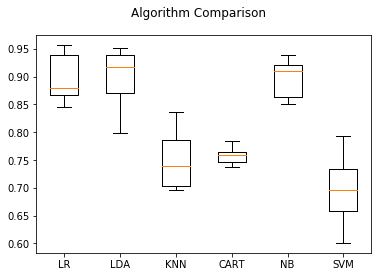

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.900222665699</span>

{'name': 'LR', 'score': 0.89754704886308656}
{'name': 'LDA', 'score': 0.90022266569908083}
{'name': 'KNN', 'score': 0.7482973209966135}
{'name': 'CART', 'score': 0.75852636671504603}
{'name': 'NB', 'score': 0.89692017416545722}
{'name': 'SVM', 'score': 0.69508043057571356}


**Training Section** for: 13 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

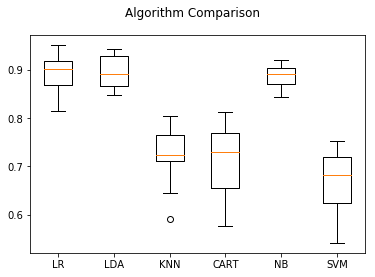

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.894795113691</span>

{'name': 'LR', 'score': 0.89127183115626507}
{'name': 'LDA', 'score': 0.89479511369134013}
{'name': 'KNN', 'score': 0.72262451620706347}
{'name': 'CART', 'score': 0.71426995645863589}
{'name': 'NB', 'score': 0.88636169569424283}
{'name': 'SVM', 'score': 0.67016061925495896}


**Training Section** for: 14 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

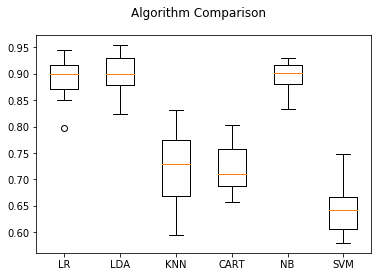

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.897605224964</span>

{'name': 'LR', 'score': 0.88898070875665225}
{'name': 'LDA', 'score': 0.89760522496371564}
{'name': 'KNN', 'score': 0.72023757256894039}
{'name': 'CART', 'score': 0.72291400580551524}
{'name': 'NB', 'score': 0.89436459845186267}
{'name': 'SVM', 'score': 0.64480064707305274}


**Training Section** for: 15 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

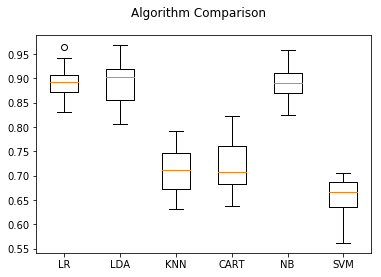

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.892904269473</span>

{'name': 'LR', 'score': 0.89290426947266577}
{'name': 'LDA', 'score': 0.89266019593613921}
{'name': 'KNN', 'score': 0.70981479801644887}
{'name': 'CART', 'score': 0.72239586357039187}
{'name': 'NB', 'score': 0.8907128688921141}
{'name': 'SVM', 'score': 0.65722245403967106}


**Training Section** for: 16 features (['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

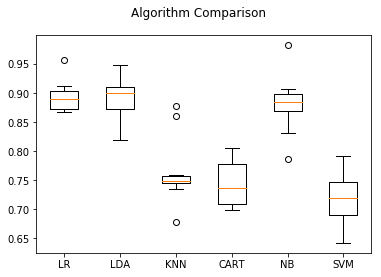

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.894137034349</span>

{'name': 'LR', 'score': 0.89337493952588287}
{'name': 'LDA', 'score': 0.89413703434929848}
{'name': 'KNN', 'score': 0.76532223633284957}
{'name': 'CART', 'score': 0.74600193517174651}
{'name': 'NB', 'score': 0.88147097242380268}
{'name': 'SVM', 'score': 0.71746335268505079}


**Training Section** for: 17 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

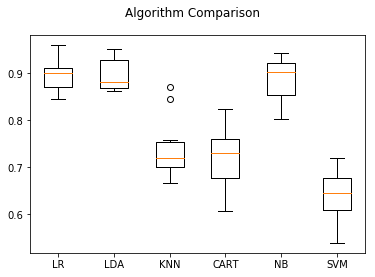

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.897612602806</span>

{'name': 'LR', 'score': 0.89761260280599908}
{'name': 'LDA', 'score': 0.89626227624576682}
{'name': 'KNN', 'score': 0.74137781204644415}
{'name': 'CART', 'score': 0.72402201257861631}
{'name': 'NB', 'score': 0.88704287614900823}
{'name': 'SVM', 'score': 0.64402001693275268}


**Training Section** for: 18 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

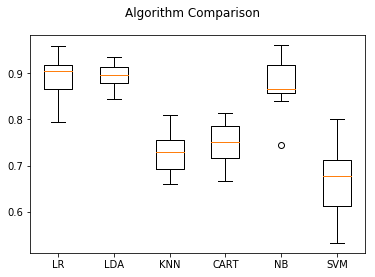

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.89547224238</span>

{'name': 'LR', 'score': 0.88935244315433004}
{'name': 'LDA', 'score': 0.89547224238026113}
{'name': 'KNN', 'score': 0.72744823415578141}
{'name': 'CART', 'score': 0.74721540880503146}
{'name': 'NB', 'score': 0.87371425979680706}
{'name': 'SVM', 'score': 0.66829853047895493}


**Training Section** for: 19 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_AGE_STARTED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

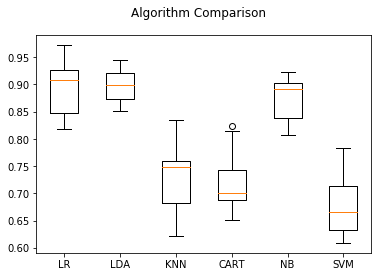

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.899002539913</span>

{'name': 'LR', 'score': 0.89536320754716991}
{'name': 'LDA', 'score': 0.89900253991291734}
{'name': 'KNN', 'score': 0.73560353168843728}
{'name': 'CART', 'score': 0.72175290275761983}
{'name': 'NB', 'score': 0.87446432027092413}
{'name': 'SVM', 'score': 0.67541733188195452}


**Training Section** for: 20 features (['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'EDUCATION_LEVEL', 'SMK_EVER_SMOKED', 'SMK_AGE_SMOKING_STOPPED', 'ALC_UNITS_PER_WEEK', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'PREFERRED_DRINK', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_ACID_TASTE', 'SYM_SORE_THROAT', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS'])

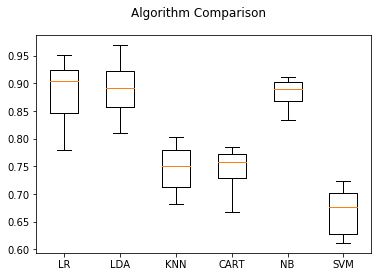

The best model for the given data is: <span style="color:green">LDA</span> with the score <span style="color:green">0.890806361877</span>

{'name': 'LR', 'score': 0.88725961538461529}
{'name': 'LDA', 'score': 0.89080636187711659}
{'name': 'KNN', 'score': 0.74473684687953567}
{'name': 'CART', 'score': 0.74713848572810837}
{'name': 'NB', 'score': 0.88162463715529749}
{'name': 'SVM', 'score': 0.66817924528301886}


In [11]:
    best_tr_results = []
    # new_trains.reverse()
    new_models = []
    for train_set in new_trains:
        X_train_mod = train_set['X_train']
        printmd("**Training Section** for: {} features ({})".format(str(X_train_mod.shape[-1]),train_set['features_name']))
        train_resultes = train_the_data(X_train_mod,Y_train,models)
        new_models.append({'train_set':train_set,'train_resultes':train_resultes})
        if train_resultes:
            best_tr = get_the_best(train_resultes)
            best_tr_results.append({"name":best_tr['name'],
                                    "score":best_tr['score'],
                                    "num_fetures":int(X_train_mod.shape[-1]),
                                    'features_names':train_set['features_name']})
            for model in train_resultes:
                print (model)

In [12]:
    for best in best_tr_results:
        print(best)
    plt.plot([d['threshold'] for d in new_trains],
             [d['ratio'] for d in new_trains],
             [rs['score'] for rs in best_tr_results])

{'name': 'CART', 'score': 0.7927810232220609, 'num_fetures': 1, 'features_names': ['SYM_YRS_SINCE_HEARTBURN_START']}
{'name': 'CART', 'score': 0.80460592041606183, 'num_fetures': 2, 'features_names': ['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START']}
{'name': 'NB', 'score': 0.82972656627963226, 'num_fetures': 3, 'features_names': ['SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'NB', 'score': 0.85379623246250613, 'num_fetures': 4, 'features_names': ['SYM_CHEST_PAIN', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'NB', 'score': 0.87285818819545236, 'num_fetures': 5, 'features_names': ['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_YRS_SINCE_HEARTBURN_START', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'name': 'NB', 'score': 0.8954497460087083, 'num_fetures': 6, 'features_names': ['SEX', 'WAIST_CIRCUMFERENCE', 'SYM_BURNING_CHEST', 'SYM_YRS_SINCE_HEART

**Training Section** for: 418976 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


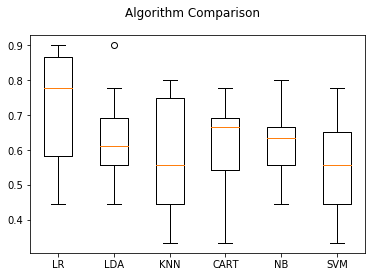

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444444</span>

{'name': 'LR', 'score': 0.7144444444444444}
{'name': 'LDA', 'score': 0.6266666666666667}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.62}
{'name': 'NB', 'score': 0.6177777777777778}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 300021 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


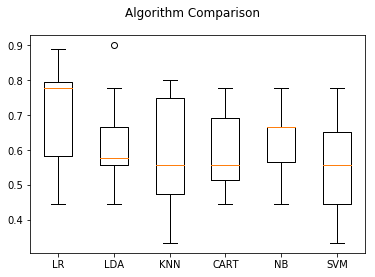

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6166666666666666}
{'name': 'KNN', 'score': 0.5822222222222222}
{'name': 'CART', 'score': 0.5977777777777777}
{'name': 'NB', 'score': 0.6211111111111112}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 249789 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


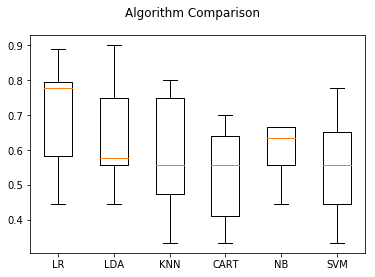

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6933333333333334</span>

{'name': 'LR', 'score': 0.6933333333333334}
{'name': 'LDA', 'score': 0.6277777777777778}
{'name': 'KNN', 'score': 0.5933333333333334}
{'name': 'CART', 'score': 0.5211111111111111}
{'name': 'NB', 'score': 0.598888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 212518 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


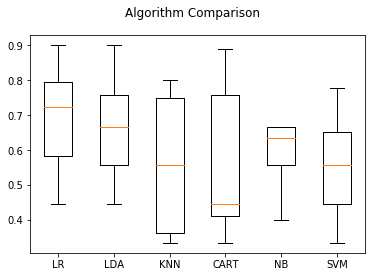

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.6922222222222223</span>

{'name': 'LR', 'score': 0.6922222222222223}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.56}
{'name': 'CART', 'score': 0.5544444444444444}
{'name': 'NB', 'score': 0.5888888888888889}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 181350 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


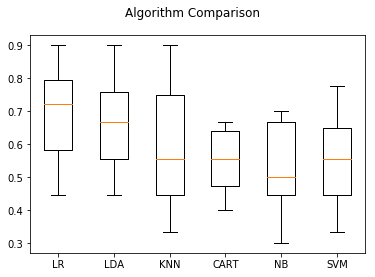

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6488888888888888}
{'name': 'KNN', 'score': 0.5811111111111111}
{'name': 'CART', 'score': 0.5466666666666666}
{'name': 'NB', 'score': 0.5333333333333334}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 153725 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


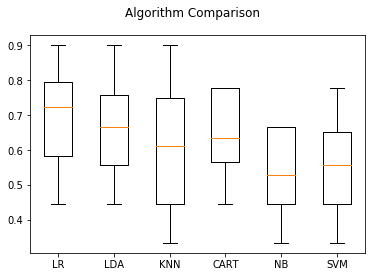

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6599999999999999}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6533333333333333}
{'name': 'NB', 'score': 0.5344444444444444}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 129439 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


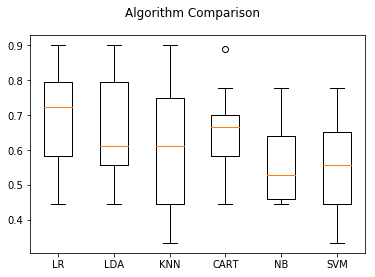

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7033333333333334</span>

{'name': 'LR', 'score': 0.7033333333333334}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5922222222222222}
{'name': 'CART', 'score': 0.6622222222222222}
{'name': 'NB', 'score': 0.5555555555555556}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 108368 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


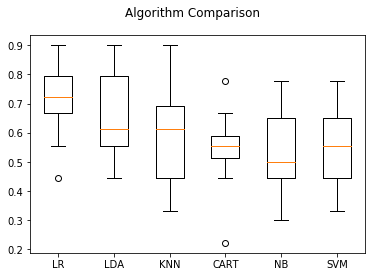

The best model for the given data is: <span style="color:green">LR</span> with the score <span style="color:green">0.7144444444444445</span>

{'name': 'LR', 'score': 0.7144444444444445}
{'name': 'LDA', 'score': 0.6588888888888889}
{'name': 'KNN', 'score': 0.5822222222222223}
{'name': 'CART', 'score': 0.5433333333333333}
{'name': 'NB', 'score': 0.5344444444444445}
{'name': 'SVM', 'score': 0.5411111111111111}


**Training Section** for: 90282 features

C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [ ]:
#need to modify the test shape
    printmd("**Testing Section:**")
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,models)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)